# This file implements Q-Learning for dataset 1

**Q-Learning and Double Q-Learning Algorithm Description**

**Q-Learning:**

Q-learning is a reinforcement learning algorithm used to find the optimal action-selection policy for a given finite Markov decision process (MDP). The algorithm uses a Q-table to store the expected utility of actions taken in specific states. The agent updates the Q-values based on the rewards received and the expected future rewards (using the Bellman equation).

**Double Q-Learning:**

Double Q-learning addresses the overestimation bias in Q-learning by using two separate Q-tables (Q1 and Q2). Each Q-table is updated independently, using the other Q-table to estimate the value of the next state.

**Implementation Steps**
1.Preprocess the Data: Load and preprocess the bank dataset.

2.Implement Q-Learning: Set up and train a Q-learning model.

3.Implement Double Q-Learning: Set up and train a Double Q-learning model.

4.Evaluate the Models: Evaluate the performance of both models.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [2]:
#Read dataset, check for null and duplicates
def read_dataset(dataset):
    
    data = pd.read_csv(dataset)
    nrow = len(data.index)
    ncol = len(data.columns)

    print("The dataset contains", format(nrow, ",d"), "rows and", ncol, "columns.")
    
    #Check for null values
    if ((data.isna().sum()).sum()) > 0:
        print("There are null items in the dataset")
    else:
        print("There are no null items in the dataset")
        
    #Check for duplicates
    
    #col_names = ["Country", "Year", "Status"]
    #(data.duplicated(subset=col_names)).sum()

    if (data.duplicated().sum()) > 0:
        print("There are duplicates in the dataset")
    else:
        print("There are no duplicates in the dataset")
        
    return data



#Function to categorize data into numeric and categorical
def categorize_data(data):
    
    numeric=[]
    categorical=[]
    numeric_dtypes = ["int64", "int32", "float64", "float32"]

    for i in range (len(data.columns)):
        if data[data.columns[i]].dtype in numeric_dtypes:
            numeric.append(data.columns[i])
        else:
            categorical.append(data.columns[i])
            
    return numeric, categorical

    
#Function to check for outliers
def outliers_check(data, numeric_cols):
    outliers_sum =[]

    for col in (numeric_cols):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (data[col] < (Q1 - 5 * IQR)) | (data[col] > (Q3 + 5 * IQR))
        print(col, "", outliers.sum())
        outliers_sum.append(outliers.sum())

    return outliers.sum()


def remove_duplicates(data):
    duplicated_sum = data.duplicated().sum()
    if duplicated_sum == 0:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        return data
    else:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        data = data[~data.duplicated()]
        print("Duplicated rows have been removed")
        return data

    
def remove_outliers(data, numeric_cols):
    
    for col in (numeric_cols):
        median_value = np.median(data[col])
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (data[col] < (Q1 - 5 * IQR)) | (data[col] > (Q3 + 5 * IQR))
        #print(col, "", outliers.sum())
        data.loc[outliers, col] = median_value
    return data


# remove special characters from columns
def remove_spec_chars(data, categorical_cols):
    for col in categorical_cols:
        data[col] = data[col].str.replace(r'\W+', '').str.strip() #replaces special characters with white sapaces and removes the white spaces
    return data


def replace_unknown(data, categorical_cols):
    for col in categorical_cols:
        if "other" in data[col].values:
            #source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html
            mode = data[col].mode()[0]
            data[col] = data[col].replace("unknown", mode)
    return data

    
def oneHotEncoding(data, categorical, drop_first):

    data_final = pd.get_dummies(data, columns=categorical, drop_first=drop_first)

    return data_final

# EDA

In [4]:
data = read_dataset("online_shoppers_intention.csv")

The dataset contains 12,330 rows and 18 columns.
There are no null items in the dataset
There are duplicates in the dataset


In [5]:
data.duplicated().sum()

125

In [6]:
data = remove_duplicates(data)

Number of duplicated rows in dataset = 125
Duplicated rows have been removed


In [7]:
data.duplicated().sum()

0

In [8]:
pd.set_option('display.max_columns', None)

data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12205 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12205 non-null  int64  
 1   Administrative_Duration  12205 non-null  float64
 2   Informational            12205 non-null  int64  
 3   Informational_Duration   12205 non-null  float64
 4   ProductRelated           12205 non-null  int64  
 5   ProductRelated_Duration  12205 non-null  float64
 6   BounceRates              12205 non-null  float64
 7   ExitRates                12205 non-null  float64
 8   PageValues               12205 non-null  float64
 9   SpecialDay               12205 non-null  float64
 10  Month                    12205 non-null  object 
 11  OperatingSystems         12205 non-null  int64  
 12  Browser                  12205 non-null  int64  
 13  Region                   12205 non-null  int64  
 14  TrafficType           

In [10]:
#Summary statistics of the dataset
data.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000
mean,2.338878,81.646331,0.508726,34.825454,32.045637,1206.982457,0.020370,0.041466,5.949574,0.061942,2.124211,2.357804,3.153298,4.073904
std,3.330436,177.491845,1.275617,141.424807,44.593649,1919.601400,0.045255,0.046163,18.653671,0.199666,0.906823,1.710114,2.402340,4.016654
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,193.000000,0.000000,0.014231,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,9.000000,0.000000,0.000000,18.000000,608.942857,0.002899,0.025000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,94.700000,0.000000,0.000000,38.000000,1477.154762,0.016667,0.048529,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [11]:
#Class imbalance
data['Revenue'].value_counts()

False    10297
True      1908
Name: Revenue, dtype: int64

In [12]:
#Categorize data into numeric and categorical

data['Weekend'] = data['Weekend'].astype('str')
data['Revenue'] = data['Revenue'].astype('str')

numeric_cols, categorical_cols = categorize_data(data)

In [13]:
data["Weekend"].dtype

dtype('O')

# Visualisations

In [17]:
#Check for outliers
outliers = outliers_check(data, numeric_cols)

Administrative  2
Administrative_Duration  273
Informational  2631
Informational_Duration  2405
ProductRelated  173
ProductRelated_Duration  166
BounceRates  691
ExitRates  0
PageValues  2730
SpecialDay  1249
OperatingSystems  0
Browser  4322
Region  0
TrafficType  261


# Correlation Analysis

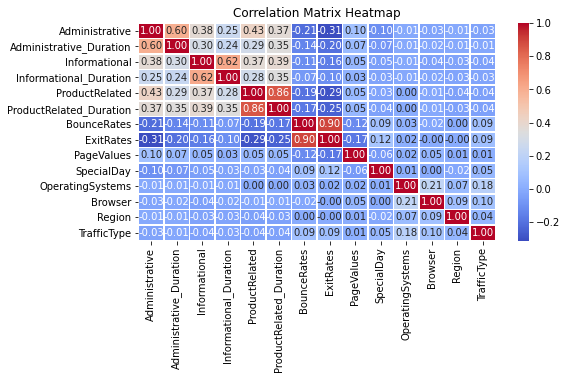

In [18]:
correlation_matrix = data.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Preprocessing

## Remove Outliers

In [19]:
#Remove outliers

removed_outliers = remove_outliers(data, numeric_cols)

## One Hot Encoding

In [20]:
#One hot encoding

data_encoded = oneHotEncoding(removed_outliers, categorical_cols, True)

data_encoded.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True,Revenue_True
0,0,0.0,0,0.0,1,0.000000,0.002899,0.20,0.0,0.0,1,2,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.10,0.0,0.0,2,2,1,2,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,0.0,0,0.0,1,0.000000,0.002899,0.20,0.0,0.0,4,2,9,3,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.14,0.0,0.0,3,2,2,4,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.05,0.0,0.0,3,2,1,4,0,1,0,0,0,0,0,0,0,0,1,1,0


In [54]:
data_encoded.shape

(12205, 27)

In [32]:
# Convert boolean columns from True/False to 1/0
binary_data = data_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))

# Check if the conversion is successful
print(binary_data.head())

   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay  OperatingSystems  Browser  \
0     0.002899       0.20         0.0         0.0                 1        2   
1     0.000000       0.10         0.0         0.0   

**Q_LEARNING MODEL**

Accuracy of Q-learning policy: 49.45
Confusion Matrix for Q-learning:
[[1035 1044]
 [ 190  172]]
Classification Report for Q-learning:
              precision    recall  f1-score   support

           0       0.84      0.50      0.63      2079
           1       0.14      0.48      0.22       362

    accuracy                           0.49      2441
   macro avg       0.49      0.49      0.42      2441
weighted avg       0.74      0.49      0.57      2441



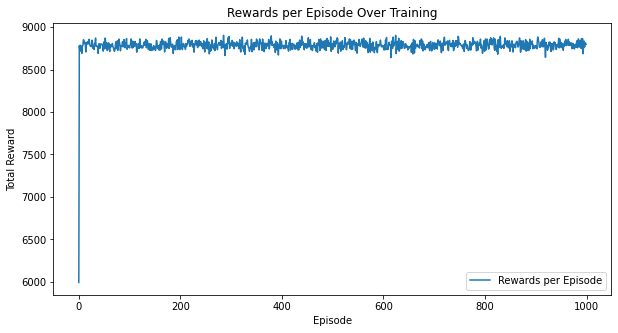

Accuracy of Double Q-learning policy: 49.82
Confusion Matrix for Double Q-learning:
[[1030 1049]
 [ 176  186]]
Classification Report for Double Q-learning:
              precision    recall  f1-score   support

           0       0.85      0.50      0.63      2079
           1       0.15      0.51      0.23       362

    accuracy                           0.50      2441
   macro avg       0.50      0.50      0.43      2441
weighted avg       0.75      0.50      0.57      2441



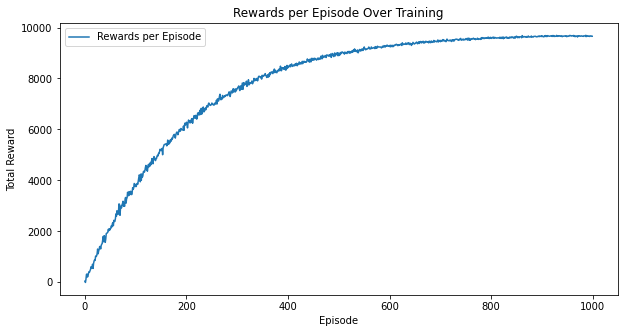

In [25]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Assuming binary_data is a DataFrame with the necessary data
# Example: binary_data = pd.read_csv('path_to_your_csv.csv')

# Define the states and actions
states = binary_data.drop(columns=['Revenue_True']).values
actions = [0, 1]  # 0: no deposit, 1: deposit

# Split data into training and testing
train_states, test_states, train_target, test_target = train_test_split(states, binary_data['Revenue_True'], test_size=0.2, random_state=42)

# Initialize Q-table
q_table = np.zeros((train_states.shape[0], len(actions)))

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration factor

# Initialize rewards_per_episode list
rewards_per_episode = []

# Training loop for Q-learning
for episode in range(1000):
    total_reward = 0
    for state_index, state in enumerate(train_states):
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice(actions)
        else:
            action = np.argmax(q_table[state_index])

        # Reward is whether the action matches the actual deposit status
        reward = 1 if action == train_target.iloc[state_index] else -1
        total_reward += reward

        # Update Q-table
        old_value = q_table[state_index, action]
        next_max = np.max(q_table[state_index])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state_index, action] = new_value
    
    # Append total reward for this episode
    rewards_per_episode.append(total_reward)

# Test the learned Q-table
predictions = []
for state in test_states:
    state_index = np.where(np.all(train_states == state, axis=1))[0]
    if state_index.size > 0:
        action = np.argmax(q_table[state_index[0]])
    else:
        action = np.random.choice(actions)  # Random action if state not in training
    predictions.append(action)

# Calculate accuracy
accuracy_rl = round(accuracy_score(test_target, predictions) * 100, 2)
print("Accuracy of Q-learning policy:", accuracy_rl)

# Print confusion matrix and classification report for Q-learning
print("Confusion Matrix for Q-learning:")
print(confusion_matrix(test_target, predictions))
print("Classification Report for Q-learning:")
print(classification_report(test_target, predictions))

# Plotting the rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode, label='Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode Over Training')
plt.legend()
plt.show()

# Scale the continuous features
scaler = StandardScaler()
train_states = scaler.fit_transform(train_states)
test_states = scaler.transform(test_states)

# Initialize Q-tables for Double Q-learning
q_table_1 = np.zeros((len(train_states), len(actions)))
q_table_2 = np.zeros((len(train_states), len(actions)))

# Hyperparameters
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 1000
rewards_per_episode = []

# Training loop for Double Q-learning
for episode in range(num_episodes):
    total_reward = 0
    for state_index, state in enumerate(train_states):
        if np.random.rand() < epsilon:
            action = np.random.choice(actions)
        else:
            action = np.argmax(q_table_1[state_index] + q_table_2[state_index])

        next_state_index = np.random.randint(0, len(train_states))
        next_state = train_states[next_state_index]
        reward = 1 if action == train_target.iloc[state_index] else -1
        total_reward += reward

        if np.random.rand() < 0.5:
            best_next_action = np.argmax(q_table_1[next_state_index])
            q_table_1[state_index, action] = (1 - alpha) * q_table_1[state_index, action] + alpha * (reward + gamma * q_table_2[next_state_index, best_next_action])
        else:
            best_next_action = np.argmax(q_table_2[next_state_index])
            q_table_2[state_index, action] = (1 - alpha) * q_table_2[state_index, action] + alpha * (reward + gamma * q_table_1[next_state_index, best_next_action])
    
    rewards_per_episode.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Testing the learned policy
predictions = []
for state in test_states:
    state_index = np.where(np.all(train_states == state, axis=1))[0]
    if state_index.size > 0:
        action = np.argmax(q_table_1[state_index[0]] + q_table_2[state_index[0]])
    else:
        action = np.random.choice(actions)  # Random action if state not in training
    predictions.append(action)

accuracy_double_q = round(accuracy_score(test_target, predictions) * 100, 2)
print("Accuracy of Double Q-learning policy:", accuracy_double_q)

# Print confusion matrix and classification report for Double Q-learning
print("Confusion Matrix for Double Q-learning:")
print(confusion_matrix(test_target, predictions))
print("Classification Report for Double Q-learning:")
print(classification_report(test_target, predictions))

# Plotting the rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode, label='Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode Over Training')
plt.legend()
plt.show()
